<a href="https://colab.research.google.com/github/AlexandreBourrieau/ML/blob/main/Carnets%20Jupyter/S%C3%A9ries%20temporelles/Bitcoin_Wavenet_Class_Multi.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Chargement des données

In [1]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import pandas as pd


import pandas as pd
import numpy as np
import seaborn as sns
import re
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFECV
from sklearn.preprocessing import MinMaxScaler, RobustScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf

In [2]:
!rm *.zip
!rm *.csv
!wget -q --no-check-certificate --content-disposition "https://github.com/AlexandreBourrieau/ML/blob/main/Carnets%20Jupyter/S%C3%A9ries%20temporelles/Bitcoin/Bitcoin_complet.zip?raw=true"
!unzip "Bitcoin_complet.zip"

rm: cannot remove '*.zip': No such file or directory
rm: cannot remove '*.csv': No such file or directory
Archive:  Bitcoin_complet.zip
  inflating: Bitcoin_complet.csv     


Charge la série sous Pandas et affiche les informations du fichier :

In [3]:
# Création de la série sous Pandas
df_data = pd.read_csv("Bitcoin_complet.csv")
df_data

,Dates,#Active_Adresses,Block Size,Block Time,FeeInReward,Price,Transaction Fee,Transaction Value,#From_Adresses,Google GTrends,Hashrate,Capitalization,Median Transaction Fee,Median Transaction Value,Difficulty,#Transactions,Profiltability,Sent,Top100,Tweets,#Active_Adresses_sma3,Block Size_sma3,Block Time_sma3,FeeInReward_sma3,Price_sma3,Transaction Fee_sma3,Transaction Value_sma3,#From_Adresses_sma3,Google GTrends_sma3,Hashrate_sma3,Capitalization_sma3,Median Transaction Fee_sma3,Median Transaction Value_sma3,Difficulty_sma3,#Transactions_sma3,Profiltability_sma3,Sent_sma3,Top100_sma3,Tweets_sma3,#Active_Adresses_sma7,...,Top100_roc14,Tweets_roc14,#Active_Adresses_roc30,Block Size_roc30,Block Time_roc30,FeeInReward_roc30,Price_roc30,Transaction Fee_roc30,Transaction Value_roc30,#From_Adresses_roc30,Google GTrends_roc30,Hashrate_roc30,Capitalization_roc30,Median Transaction Fee_roc30,Median Transaction Value_roc30,Difficulty_roc30,#Transactions_roc30,Profiltability_roc30,Sent_roc30,Top100_roc30,Tweets_roc30,#Active_Adresses_roc90,Block Size_roc90,Block Time_roc90,FeeInReward_roc90,Price_roc90,Transaction Fee_roc90,Transaction Value_roc90,#From_Adresses_roc90,Google GTrends_roc90,Hashrate_roc90,Capitalization_roc90,Median Transaction Fee_roc90,Median Transaction Value_roc90,Difficulty_roc90,#Transactions_roc90,Profiltability_roc90,Sent_roc90,Top100_roc90,Tweets_roc90
0,2014-08-30,150886.0,186250.0,7.912,0.201,502.665,0.0752,4962.0,101469.0,7.377,2.040071e+17,6.587252e+09,0.0503,79.849,2.384467e+10,61032.0,11.234,2.326117e+08,19.946,18905.0,155328.666667,207422.000000,8.235667,0.228667,506.365000,0.076600,4901.666667,110979.000000,7.296333,2.055306e+17,6.624317e+09,0.050667,101.313333,2.384467e+10,65977.000000,10.804333,2.817489e+08,19.879667,20324.000000,164702.571429,...,2.114371,-19.508664,-2.992780,-29.809685,-15.388728,-31.164384,-12.569204,-19.139785,42.340792,-13.373572,-9.540159,34.502450,-11.983567,-12.521739,-22.974746,27.263600,-12.319163,-23.244056,23.159820,3.588678,-14.688628,-21.140408,-9.125063,-3.852230,-18.292683,-22.005409,-40.317460,-43.478756,-4.659488,-25.477321,128.784743,-19.517102,-21.894410,-47.650985,128.053828,10.872527,-64.560396,-47.014142,0.737374,47.132073
1,2014-08-31,177973.0,179521.0,7.660,0.189,488.836,0.0755,4343.0,102679.0,7.740,2.245391e+17,6.389446e+09,0.0489,93.017,2.390186e+10,57567.0,10.252,2.101746e+08,19.938,17226.0,157914.333333,192453.666667,8.014333,0.211667,499.380000,0.075967,4543.333333,104920.666667,7.417333,2.105118e+17,6.532561e+09,0.049967,96.025667,2.386373e+10,62347.666667,10.706667,2.398264e+08,19.911333,18656.333333,162913.571429,...,2.036847,-23.805732,16.226506,-26.185924,-16.484954,-30.514706,-17.296009,-18.991416,8.466533,-12.470590,4.920699,55.753823,-16.770244,-17.258883,-19.567473,27.568839,-15.040290,-36.465047,-7.094303,3.113364,-20.194580,1.440329,-10.034829,2.667203,-22.222222,-23.122313,-34.913793,-53.104416,-12.412352,-13.257873,143.057467,-20.689616,-23.113208,-37.208800,128.600810,-10.389004,-69.204890,-63.327065,0.732582,4.863944
2,2014-09-01,169807.0,296280.0,10.588,0.321,479.421,0.0745,4833.0,117614.0,9.070,2.217182e+17,6.309097e+09,0.0479,97.231,2.742863e+10,70247.0,7.375,2.772926e+08,19.890,18661.0,166222.000000,220683.666667,8.720000,0.237000,490.307333,0.075067,4712.666667,107254.000000,8.062333,2.167548e+17,6.428598e+09,0.049033,90.032333,2.505839e+10,62948.666667,9.620333,2.400263e+08,19.924667,18264.000000,164547.714286,...,1.707916,-14.661362,32.607847,55.838418,19.855105,54.326923,-18.800007,-18.311404,17.849305,25.836133,38.876129,47.890157,-17.237931,-18.813559,1.814698,46.391890,28.127166,-54.141276,53.263001,2.721686,0.701527,-9.464755,26.216239,30.877627,6.291391,-27.843900,-41.796875,-43.750000,-8.698251,-16.597701,124.097209,-24.474173,-27.861446,-40.218882,162.331342,1.050103,-75.395343,-48.746650,0.368371,4.496584
3,2014-09-02,163408.0,282380.0,9.796,0.315,477.176,0.0771,3921.0,123859.0,7.982,1.951898e+17,6.273471e+09,0.0477,102.216,2

# Analyse des indicateurs obtenus par RF

In [4]:
!rm *.zip
!wget --no-check-certificate --content-disposition "https://github.com/AlexandreBourrieau/ML/blob/main/Carnets%20Jupyter/S%C3%A9ries%20temporelles/Bitcoin/Bitcoin_X_one.zip?raw=true"
!wget --no-check-certificate --content-disposition "https://github.com/AlexandreBourrieau/ML/blob/main/Carnets%20Jupyter/S%C3%A9ries%20temporelles/Bitcoin/Bitcoin_Y_one.zip?raw=true"
!unzip "Bitcoin_X_one.zip"
!unzip "Bitcoin_Y_one.zip"

--2021-05-06 20:52:33--  https://github.com/AlexandreBourrieau/ML/blob/main/Carnets%20Jupyter/S%C3%A9ries%20temporelles/Bitcoin/Bitcoin_X_one.zip?raw=true
Resolving github.com (github.com)... 140.82.121.3
Connecting to github.com (github.com)|140.82.121.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/AlexandreBourrieau/ML/raw/main/Carnets%20Jupyter/S%C3%A9ries%20temporelles/Bitcoin/Bitcoin_X_one.zip [following]
--2021-05-06 20:52:33--  https://github.com/AlexandreBourrieau/ML/raw/main/Carnets%20Jupyter/S%C3%A9ries%20temporelles/Bitcoin/Bitcoin_X_one.zip
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/AlexandreBourrieau/ML/main/Carnets%20Jupyter/S%C3%A9ries%20temporelles/Bitcoin/Bitcoin_X_one.zip [following]
--2021-05-06 20:52:33--  https://raw.githubusercontent.com/AlexandreBourrieau/ML/main/Carnets%20Jupyter/S%C3%A9ries%20temporelles/Bitcoin/

In [5]:
df_X_one = pd.read_csv("Bitcoin_X_one.csv").iloc[:,1:]
df_Y_one = pd.read_csv("Bitcoin_Y_one.csv")['Price']

**1. Cross-Validation sur les variables retenues**

Comparons les résultats obtenus par régression avec les variables retenues  :

In [6]:
var_thres = [593,671,386,82,367,485,10,101,63,196,177,612,599,618,308,656,124,314,476,637,675,67,631,175,333,493,143,162,48,365,371,61,29,118,194,139,669,99,352,95,346,156,200,190,181,80,158,384,105,650,137,42,327,86,640,206,683,390,157,329,487,348,163,480,388,347,23,396,474,621,486,189,372,103,176,199,366,203,391,104,182,202,398,385,107,111,392,670,198,379,85,100,481,676,674,491,389,195,208,113,652,106,201,108,129,146,184,355,62,479,70,659,68,127,393,336,165,678,374,89,51,32,317,370,47,186,81,680,395,188,205,397,110,378,633,44,180,94,87,93,25,120,558,96,64,169,682,359,187,681,602,13,207,515,319,677,445,777,302,310,662,623,604,570,167,376,74,433,150,183,148,340,33,131,338,191,17,66,138,470,625,642,98,112,673,168,357,383,360,575,569,321,34,387,606,170,350,380,36,465,550,356,484,455,19,52,456,587,614,473,84,567,477,471,581,102,577,91,160,358,459,644,298,540,586,351,739,53,533,55,353,313,568,583,76,193,15,464,451,97,564,65,663,542,457,133,38,539,349,79,192,54,469,665,178,483,536,166,381,490,664,83,544,444,56,655,415,161,472,45,559,654,588,440,467,109,369,563,50,72,142,454,362,149,595,448,197,323,171,334,566,627,628,332,492,574,179,773,557,151,585,185,377,560,580,571,672,518,78,330,75,608,579,463,489,534,427,43,555,421,152,219,425,49,58,270,572,661,213,295,164,402,638,561,382,690,26,668,222,141,276,289,514,541,565,342,394,418,204,646,46,636,361,60,368,92,666,232,144]
var_interp = [593,671,386,82,367,485,10,101,63,196,177,612,599,618,308,656,124,314,476,637,675,67,631,175,333,493,143,162,48,365,371,61,29,118,194,139,669,99,352,95,346,156,200,190,181,80,158,384,105,650,137,42,327,86,640,206,683,390,157,329,487,348,163,480,388,347,23,396,474,621,486,189,372,103,176,199,366,203,391,104,182,202,398,385,107,111,392,670,198,379,85,100,481,676,674,491,389,195,208,113,652,106,201,108,129,146,184,355,62,479,70,659,68,127,393,336,165,678,374,89,51,32,317,370,47,186,81,680,395,188,205,397,110,378,633,44,180,94,87,93,25,120,558,96,64,169,682,359,187,681,602,13,207,515,319,677,445,777,302,310,662,623,604,570,167,376,74,433,150,183,148,340,33,131,338,191,17,66,138,470,625,642,98,112,673,168,357,383,360,575,569,321,34,387,606,170,350,380,36,465,550,356,484,455,19,52,456,587,614,473]
var_pred = [593,671,386,101,675,67,175,493,194,669,99,640,683,390,621,486,372,89,51,32,473]

var_thres = np.subtract(var_thres,1).tolist()
var_interp = np.subtract(var_interp,1).tolist()
var_pred = np.subtract(var_pred,1).tolist()

df_all = df_X_one
df_thres = df_X_one.iloc[:,var_thres]
df_interp = df_X_one.iloc[:,var_interp]
df_pred = df_X_one.iloc[:,var_pred]

#df_ = [df_all, df_thres, df_interp,df_pred]
#df_ = [df_thres, df_interp,df_pred]
#df_ = [df_interp,df_pred]
df_ = [df_pred]


In [ ]:
df_pred

In [7]:
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error

kf = KFold(n_splits=5)

means = []

for df in df_:
  print("# Variables : %d" %len(df.columns))
  n_arbres = 500
  m_try = len(df.columns)
  clf = RandomForestRegressor(n_estimators=n_arbres, bootstrap=True, oob_score=True, max_features=m_try, n_jobs=-1)

  for train_index, test_index in kf.split(df):
    test_index = train_index
    clf.fit(df.iloc[train_index],np.asarray(df_Y_one.iloc[train_index]))
    y_predict = clf.predict(df.iloc[test_index])
    mse = mean_squared_error(y_predict,df_Y_one.iloc[test_index])
    print(mse)

# Variables : 21


KeyboardInterrupt: ignored

**2. Cross validation sur des variables tirées au hasard**


In [ ]:
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error

kf = KFold(n_splits=5)

n = 21
n_arbres = 500
m_try = n

clf = RandomForestRegressor(n_estimators=n_arbres, bootstrap=True, oob_score=True, max_features=m_try, n_jobs=-1)
for i in range(1,1000):
  df_all = df_X_one
  index = np.random.randint(0,778,n)
  df = df_all.iloc[:,index]
  print("%s" %index)

  for train_index, test_index in kf.split(df):
    test_index = train_index
    clf.fit(df.iloc[train_index], np.asarray(df_Y_one.iloc[train_index]))
    y_predict = clf.predict(df.iloc[test_index])
    mse = mean_squared_error(y_predict,df_Y_one.iloc[test_index])
    print(mse)

**3. Corrélation des variables retenues**

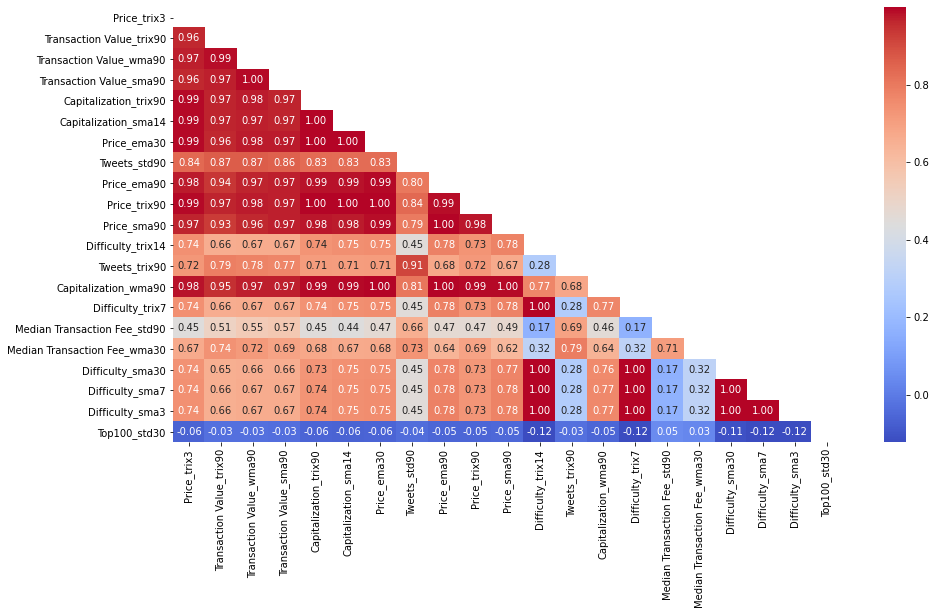

In [8]:
corr = df_pred.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=np.bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(15, 8))

sns.heatmap(corr,mask=mask, cmap='coolwarm',annot=True, fmt='.2f')

**4. VIF**

In [ ]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

#function for removing features with high vif
def drop_high_vif(X, thresh=100):
    cols = X.columns
    variables = np.arange(X.shape[1])
    dropped=True
    while dropped:
        dropped=False
        c = X[cols[variables]].values
        vif = [variance_inflation_factor(c, ix) for ix in np.arange(c.shape[1])]

        maxloc = vif.index(max(vif))
        if max(vif) > thresh:
            print('dropping \'' + X[cols[variables]].columns[maxloc] + '\' at index: ' + str(maxloc))
            variables = np.delete(variables, maxloc)
            dropped=True

    print('Remaining variables:')
    print(X.columns[variables])
    return X[cols[variables]]

#function for listing vif values
def vif_values(X):
    add_constant(X)
    df=pd.Series([variance_inflation_factor(X.values, i) for i in range(X.shape[1])], index=X.columns)
    return df


In [ ]:
X_reduit_VIF = drop_high_vif(df_pred,thresh=10)
X_reduit_VIF

In [ ]:
corr = X_reduit_VIF.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=np.bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(15, 8))

sns.heatmap(corr,mask=mask, cmap='coolwarm',annot=True, fmt='.2f')

# Quantification

In [28]:
X_Avec_Prix = df_data
X_Avec_Prix = X_Avec_Prix.drop(columns=['Dates', 'Price'])
Xdrop = SimpleImputer(missing_values=np.nan,strategy='most_frequent').fit_transform(X_Avec_Prix)
Xdrop = pd.DataFrame(Xdrop)
Xdrop.columns = X_Avec_Prix.columns
X_Avec_Prix = Xdrop
X_Avec_Prix = X_Avec_Prix
X_Avec_Prix = X_Avec_Prix.iloc[:,var_pred]
X_Avec_Prix.insert(0,'Price',df_data['Price'])
X_Avec_Prix

,Price,Price_trix3,Transaction Value_trix90,Transaction Value_wma90,Transaction Value_sma90,Capitalization_trix90,Capitalization_sma14,Price_ema30,Tweets_std90,Price_ema90,Price_trix90,Price_sma90,Difficulty_trix14,Tweets_trix90,Capitalization_wma90,Difficulty_trix7,Median Transaction Fee_std90,Median Transaction Fee_wma30,Difficulty_sma30,Difficulty_sma7,Difficulty_sma3,Top100_std30
0,502.665,502.896486,5627.621788,5405.723810,5631.100000,7.535826e+09,6.527684e+09,532.611494,3157.049204,588.578428,584.843512,588.933267,2.445454e+10,19560.757414,7.347748e+09,2.389215e+10,0.004803,0.051876,2.102089e+10,2.384467e+10,2.384467e+10,0.164101
1,488.836,490.004663,5543.811872,5377.413919,5576.455556,7.460525e+09,6.519881e+09,529.787269,3148.930980,586.386287,578.533240,587.299644,2.442159e+10,19409.232580,7.321506e+09,2.387996e+10,0.004891,0.051563,2.119307e+10,2.385284e+10,2.386373e+10,0.172641
2,479.421,479.293991,5495.275745,5361.074237,5534.688889,7.383348e+09,6.545086e+09,526.537832,3144.839341,584.035401,571.892825,585.244078,2.560602e+10,19356.884080,7.293904e+09,2.590544e+10,0.004953,0.051206,2.148281e+10,2.436483e+10,2.505839e+10,0.176796
3,477.176,475.793424,5390.077526,5325.608547,5467.077778,7.307283e+09,6.559739e+09,523.353198,3157.696653,581.686843,565.401051,583.418000,2.647010e+10,19580.341937,7.266019e+09,2.701003e+10,0.005045,0.050861,2.177255e+10,2.487683e+10,2.625304e+10,0.179679
4,475.398,474.403351,5248.440352,5277.628816,5401.422222,7.232698e+09,6.548938e+09,520.259314,3165.512264,579.350824,559.083579,581.463844,2.708592e+10,19743.304418,7.237929e+09,2.756006e+10,0.005121,0.050525,2.206229e+10,2.538882e+10,2.742863e+10,0.181297
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2428,49891.000,50271.303907,364703.552330,314635.883028,298779.222222,1.166655e+12,1.092275e+12,57012.453918,32907.738375,50511.906509,62434.836781,50979.333333,2.366659e+13,114707.987853,1.029652e+12,2.359981e+13,4.942729,15.733026,2.291706e+13,2.358198e+13,2.358198e+13,0.113671
2429,50077.000,49740.497274,360643.453301,314131.834188,299706.333333,1.156761e+12,1.079254e+12,56565.005278,32494.548974,50502.348124,61902.581955,51177.522222,2.366021e+13,113186.978260,1.029321e+12,2.359144e+13,4.889702,15.737946,2.297428e+13,2.358198e+13,2.358198e+13,0.119850
2430,49657.000,49469.774482,360690.917599,314958.112576,300679.933333,1.146690e+12,1.065769e+12,56119.327518,32309.000469,50483.769044,61360.866494,51358.644444,2.365141e+13,111416.060134,1.028736e+12,2.358457e+13,4.862619,15.500428,2.303149e+13,2.358198e+13,2.358198e+13,0.129055
2431,53000.000,52472.951755,369539.942232,318773.740415,304149.111111,1.140990e+12,1.056326e+12,55918.080581,31920.080339,50539.070823,61053.046985,51591.411111,2.364131e+13,111605.050933,1.029450e+12,2.357935e+13,4.867598,15.791718,2.308871e+13,2.358198e+13,2.358198e+13,0.135769


In [29]:
X_Avec_Prix_quant16bits = pd.DataFrame()

for colonne in X_Avec_Prix:
  data_quant = tf.quantization.quantize(X_Avec_Prix[colonne],X_Avec_Prix[colonne].min(),X_Avec_Prix[colonne].max(),tf.quint8)
  X_Avec_Prix_quant16bits[colonne] = np.array(data_quant.output)

In [30]:
X_Avec_Prix_quant16bits

,Price,Price_trix3,Transaction Value_trix90,Transaction Value_wma90,Transaction Value_sma90,Capitalization_trix90,Capitalization_sma14,Price_ema30,Tweets_std90,Price_ema90,Price_trix90,Price_sma90,Difficulty_trix14,Tweets_trix90,Capitalization_wma90,Difficulty_trix7,Median Transaction Fee_std90,Median Transaction Fee_wma30,Difficulty_sma30,Difficulty_sma7,Difficulty_sma3,Top100_std30
0,2,2,4,4,5,2,1,2,22,3,2,3,0,40,2,0,0,1,0,0,0,27
1,2,2,4,4,5,2,1,2,22,3,2,3,0,40,2,0,0,1,0,0,0,28
2,2,2,4,4,5,2,1,2,21,3,2,3,0,40,2,0,0,1,0,0,0,29
3,2,2,4,4,5,2,1,2,22,3,2,3,0,40,2,0,0,1,0,0,0,30
4,2,2,4,4,4,2,1,2,22,3,2,3,0,41,2,0,0,1,0,0,0,30
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2428,201,202,248,250,248,249,249,249,225,254,248,251,255,235,255,255,140,195,252,255,255,19
2429,201,200,246,249,249,246,246,247,222,254,246,252,255,232,255,255,138,195,253,255,255,20
2430,200,199,246,250,250,244,243,245,221,254,244,253,255,229,255,255,137,192,254,255,255,21
2431,213,211,252,253,253,243,241,244,218,255,243,254,255,229,255,255,137,196,254,255,255,22


**1. Séparation des données en données pour l'entrainement et la validation**

On réserve 20% des données pour l'entrainement et le reste pour la validation :

In [31]:
# Sépare les données en entrainement et tests
pourcentage = 0.8
temps_separation = int(len(X_Avec_Prix_quant16bits) * pourcentage)
date_separation = X_Avec_Prix_quant16bits.index[temps_separation]

serie_entrainement_X = []
serie_test_X = []

for column in X_Avec_Prix_quant16bits:
  serie_entrainement_X.append(np.array(X_Avec_Prix_quant16bits[column][:temps_separation],dtype=np.uint16))
  serie_test_X.append(np.array(X_Avec_Prix_quant16bits[column][temps_separation:],dtype=np.uint16))

print("Taille de l'entrainement : %d" %len(serie_entrainement_X[0]))
print("Taille de la validation : %d" %len(serie_test_X[0]))

Taille de l'entrainement : 1946
Taille de la validation : 487


In [ ]:
# Affiche la série X
fig, ax = plt.subplots(constrained_layout=True, figsize=(15,5))

for i in range(0,len(X_Avec_Prix_quant16bits.columns)):
  ax.plot(X_Avec_Prix_quant16bits.index[:temps_separation].values,serie_entrainement_X[i], label="X_Ent")
  ax.plot(X_Avec_Prix_quant16bits.index[temps_separation:].values,serie_test_X[i], label="X_Val")

ax.legend()
plt.show()

# Création des datasets

In [52]:
# Fonction permettant de créer un dataset à partir des données de la série temporelle

def prepare_dataset_XY(series, taille_fenetre, horizon, batch_size):
  serie_concat = tf.expand_dims(series[0],1)

  for i in range(1,len(series)):
    serie_ = tf.expand_dims(series[i],1)
    serie_concat = tf.concat([serie_concat,serie_],1)

  dataset = tf.data.Dataset.from_tensor_slices(serie_concat)
  dataset = dataset.window(taille_fenetre+horizon, shift=1, drop_remainder=True)
  dataset = dataset.flat_map(lambda x: x.batch(taille_fenetre + horizon))
  dataset = dataset.map(lambda x: (x[0:taille_fenetre],tf.expand_dims(x[-1:][:,0],1)))

  dataset = dataset.batch(batch_size,drop_remainder=True).prefetch(1)
  return dataset

In [55]:
# Définition des caractéristiques du dataset que l'on souhaite créer
taille_fenetre = 16
horizon = 1
batch_size = 1

# Création du dataset
dataset = prepare_dataset_XY(serie_entrainement_X,taille_fenetre,horizon,batch_size)
dataset_val = prepare_dataset_XY(serie_test_X,taille_fenetre,horizon,batch_size)

In [54]:
print(len(list(dataset.as_numpy_iterator())))
for element in dataset.take(1):
  print(element[0].shape)
  print(element[1].shape)

1945
(1, 1, 22)
(1, 1, 1)


In [ ]:
for element in dataset.take(2):
  print(element)


On extrait maintenant les deux tenseurs (X,Y) pour l'entrainement :

In [56]:
# Extrait les X,Y du dataset
x,y = tuple(zip(*dataset))              # #60x((32,16,22),(32,1,1)) => x = 60x(32,16,22) ; y = 60x(32,1,1)

# Recombine les données
x = np.asarray(x,dtype=np.float32)      # 60x(32,16,22) => (60,32,16,22)
y = np.asarray(y,dtype=np.float32)      # 60x(32,1,1) => (60,32,1,1)

x_train = np.asarray(tf.reshape(x,shape=(x.shape[0]*x.shape[1],taille_fenetre,x.shape[3])))     # (60,32,16,22) => (60*32,16,22)
y_train = np.asarray(tf.reshape(y,shape=(y.shape[0]*y.shape[1],1,y.shape[3])))     # (60,32,1,1) => (60*32,1,1)

Puis la même chose pour les données de validation :

In [57]:
# Extrait les X,Y du dataset
x,y = tuple(zip(*dataset_val))              # #60x((32,16,22),(32,1,1)) => x = 60x(32,16,22) ; y = 60x(32,1,1)

# Recombine les données
x = np.asarray(x,dtype=np.float32)      # 60x(32,16,22) => (60,32,16,22)
y = np.asarray(y,dtype=np.float32)      # 60x(32,1,1) => (60,32,1,1)

x_val = np.asarray(tf.reshape(x,shape=(x.shape[0]*x.shape[1],taille_fenetre,x.shape[3])))     # (60,32,16,22) => (60*32,16,22)
y_val = np.asarray(tf.reshape(y,shape=(y.shape[0]*y.shape[1],1,y.shape[3])))     # (60,32,1,1) => (60*32,1,1)

In [58]:
y_train = tf.squeeze(tf.one_hot(y_train,256),1)
y_val = tf.squeeze(tf.one_hot(y_val,256),1)

# Création du modèle type Wavenet Multivarié Classification

**1. Création du réseau**

In [37]:
from keras.layers import Conv1D
from keras.layers import Conv1D
from keras.utils.conv_utils import conv_output_length
from keras import layers
from keras.regularizers import l2
import keras.backend as K
from keras.engine import Input
from keras.engine import Model

In [38]:
class CausalDilatedConv1D(Conv1D):
    def __init__(self, nb_filter, filter_length, init='glorot_uniform', activation=None, weights=None,
                 border_mode='valid', subsample_length=1, atrous_rate=1, W_regularizer=None, b_regularizer=None,
                 activity_regularizer=None, W_constraint=None, b_constraint=None, bias=True, causal=False, **kwargs):
        super(CausalDilatedConv1D, self).__init__(nb_filter, filter_length, weights=weights, activation=activation, 
                padding=border_mode, strides=subsample_length, dilation_rate=atrous_rate, kernel_regularizer=W_regularizer, 
                bias_regularizer=b_regularizer, activity_regularizer=activity_regularizer, kernel_constraint=W_constraint, 
                bias_constraint=b_constraint, use_bias=bias, **kwargs)
        self.causal = causal
        self.nb_filter = nb_filter
        self.atrous_rate = atrous_rate
        self.filter_length = filter_length
        self.subsample_length = subsample_length
        self.border_mode = border_mode
        if self.causal and border_mode != 'valid':
            raise ValueError("Causal mode dictates border_mode=valid.")

    def compute_output_shape(self, input_shape):
        input_length = input_shape[1]
        if self.causal:
            input_length += self.atrous_rate * (self.filter_length - 1)
        length = conv_output_length(input_length, self.filter_length, self.border_mode, self.strides[0], dilation=self.atrous_rate)
        return (input_shape[0], length, self.nb_filter)

    def call(self, x, mask=None):
        if self.causal:
            x = K.temporal_padding(x, padding=(self.atrous_rate * (self.filter_length - 1), 0))
        # return super(CausalAtrousConvolution1D, self).call(x, mask)
        return super(CausalDilatedConv1D, self).call(x)

In [39]:
def _compute_receptive_field(dilation_depth, stacks):
  return stacks * (2 ** dilation_depth * 2) - (stacks - 1)

In [119]:
def build_model_residual_block(x, i, s,nb_filters, dim_filters, use_bias,res_l2,output_bins):
        original_x = x
        # TODO: initalization, regularization?
        relu_out = CausalDilatedConv1D(nb_filters, dim_filters, atrous_rate=2 ** i, border_mode='valid', causal=True, bias=True, name='dilated_conv_%d_relu_s%d' % (2 ** i, s), activation='tanh', W_regularizer=l2(res_l2))(x)
        res_x = layers.Conv1D(output_bins, 1, padding='same', use_bias=use_bias, kernel_regularizer=l2(res_l2))(relu_out)
        skip_x = layers.Conv1D(output_bins, 1, padding='same', use_bias=use_bias, kernel_regularizer=l2(res_l2))(relu_out)
        res_x = layers.Add()([original_x, res_x])
        return res_x, skip_x

def build_model_couche_condition(x, Nbr_Inputs, output_bins, nb_filters, dim_filters, use_bias,res_l2):
        original_x = x
        skip_conditions = []

        relu_out = CausalDilatedConv1D(nb_filters, dim_filters, atrous_rate=1, border_mode='valid', causal=True, bias=True, name='dilated_conv_%d_condition_%d_s%d' % (1,1, 0), activation='tanh',
                                       W_regularizer=l2(res_l2))(tf.expand_dims(x[:,:,0],2))

        skip_ = layers.Conv1D(output_bins, 1, padding='same', use_bias=use_bias, kernel_regularizer=l2(res_l2))(relu_out)
        skip_conditions.append(skip_)

        for i in range(1,Nbr_Inputs-1):
          relu_out = CausalDilatedConv1D(nb_filters, dim_filters, atrous_rate=1, border_mode='valid', causal=True, bias=True, name='dilated_conv_%d_condition_%d_s%d' % (1,i+1,0), activation='tanh',
                                                    W_regularizer=l2(res_l2))(tf.expand_dims(x[:,:,i],2))

          skip_ = layers.Conv1D(output_bins, 1, padding='same', use_bias=use_bias, kernel_regularizer=l2(res_l2))(relu_out)
          skip_conditions.append(skip_)

        if Nbr_Inputs > 1:
          print(len(skip_conditions))
          out = layers.Add()(skip_conditions)
        else:
          out = skip_
        return out


def build_model(fragment_length, nb_filters, dim_filters, Nbr_Inputs, output_bins, dilation_depth, stacks, use_skip_connections, use_bias, res_l2, final_l2):
        input_shape = Input(shape=(fragment_length, Nbr_Inputs), name='input_part')
        out = input_shape
        skip_connections = []

        for s in range(stacks):
            # Couche conditionnée
            out = build_model_couche_condition(out, Nbr_Inputs, output_bins, nb_filters, dim_filters, use_bias, res_l2)

            # Couches intermédiaires
            for i in range(1, dilation_depth + 1):
                out, skip_out = build_model_residual_block(out, i, s, nb_filters, dim_filters, use_bias, res_l2,output_bins)
                skip_connections.append(skip_out)

        if use_skip_connections:
            out = layers.Add()(skip_connections)

        # Couche de sortie
#        out = layers.Activation('relu')(out)
#        out = layers.Conv1D(output_bins, 1, padding='same', kernel_regularizer=l2(final_l2))(out)
        out = layers.Conv1D(output_bins, 1, padding='same')(out)
        out = layers.Activation('tanh')(out)
#        out = layers.Conv1D(output_bins, 1, padding='same')(out)
        out = layers.Dense(16)(out[:,0,:])
        out = layers.Dense(output_bins,activation="softmax")(out)

        model = Model(input_shape,tf.expand_dims(out,-1))
        return model


**2. Construction du modèle**

In [122]:
def compute_receptive_field_(dilation_depth, nb_stacks):
    receptive_field = nb_stacks * (2 ** dilation_depth * 2) - (nb_stacks - 1)
    return receptive_field

nb_filters = 256
dim_filters = 5
Nbr_Inputs = 22
output_bins = 256
dilation_depth = 3
nb_stacks = 1
use_skip_connections = False
use_bias = False
res_l2 = 0
final_l2 = 0

fragment_length = compute_receptive_field_(dilation_depth, nb_stacks)
fragment_length

model = build_model(fragment_length, nb_filters, dim_filters, Nbr_Inputs, output_bins, dilation_depth, nb_stacks, use_skip_connections, use_bias, res_l2, final_l2)
model.summary()

21
Model: "model_18"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_part (InputLayer)         [(None, 16, 22)]     0                                            
__________________________________________________________________________________________________
tf.__operators__.getitem_522 (S (None, 16)           0           input_part[0][0]                 
__________________________________________________________________________________________________
tf.__operators__.getitem_523 (S (None, 16)           0           input_part[0][0]                 
__________________________________________________________________________________________________
tf.__operators__.getitem_524 (S (None, 16)           0           input_part[0][0]                 
________________________________________________________________________________________

In [ ]:
y_train

In [85]:
y_train = tf.reshape(y_train,(1930,256,1))

In [86]:
y_val = tf.reshape(y_val,(471,256,1))

In [27]:
from keras import *
from keras.layers import *

model = Sequential()
model.add(Input(shape=(1,22)))
model.add(Bidirectional(LSTM(80, return_sequences=True, activation='relu')))
model.add(Bidirectional(LSTM(100, return_sequences=True, activation='relu')))
#model.add(Bidirectional(LSTM(40, return_sequences=True, activation='relu')))
model.add(Dense(65536,activation='softmax'))
model.compile(loss="categorical_crossentropy", optimizer=tf.keras.optimizers.Adam(0.001), metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional (Bidirectional (None, 1, 160)            65920     
_________________________________________________________________
bidirectional_1 (Bidirection (None, 1, 200)            208800    
_________________________________________________________________
dense (Dense)                (None, 1, 65536)          13172736  
Total params: 13,447,456
Trainable params: 13,447,456
Non-trainable params: 0
_________________________________________________________________


In [ ]:
from keras.callbacks import *


mcp_save = ModelCheckpoint('LSTM_cls_interval3.hdf5', save_best_only=True, monitor='val_loss', mode='max')
earlyStopping = EarlyStopping(monitor='val_loss', patience=50, verbose=1, mode='max')

In [ ]:
model.fit(x=x_train,y=y_train,validation_data=(x_val,y_val),epochs=5000, shuffle=False)


In [ ]:
model.predict(x_train)

# Entrainement du modèle

**1. Optimisation de l'apprentissage**

Pour accélérer le traitement des données, nous n'allons pas utiliser l'intégralité des données pendant la mise à jour du gradient, comme cela a été fait jusqu'à présent (en utilisant le dataset).  
Cette fois-ci, nous allons forcer les mises à jour du gradient à se produire de manière moins fréquente en attribuant la valeur du batch_size à prendre en compte lors de la regression du modèle.  
Pour cela, on utilise l'argument "batch_size" dans la méthode fit. En précisant un batch_size=1000, cela signifie que :
 - Sur notre total de 56000 échantillons, 56 seront utilisés pour les calculs du gradient
 - Il y aura également 56 itérations à chaque période.
  
    
    
Si nous avions pris le dataset comme entrée, nous aurions eu :
- Un total de 56000 échantillons également
- Chaque période aurait également pris 56 itérations pour se compléter
- Mais 1000 échantillons auraient été utilisés pour le calcul du gradient, au lieu de 56 avec la méthode utilisée.

In [123]:
# Définition de la fonction de régulation du taux d'apprentissage
def RegulationTauxApprentissage(periode, taux):
  return 1e-8*10**(periode/10)

# Définition de l'optimiseur à utiliser
#optimiseur=tf.keras.optimizers.Adam()
optimiseur=tf.keras.optimizers.SGD()

# Compile le modèle
model.compile(loss="categorical_crossentropy", optimizer=optimiseur, metrics=["accuracy"])

# Utilisation de la méthode ModelCheckPoint
CheckPoint = tf.keras.callbacks.ModelCheckpoint("poids.hdf5", monitor='accuracy', verbose=1, save_best_only=True, save_weights_only = True, mode='auto', save_freq='epoch')

# Entraine le modèle en utilisant notre fonction personnelle de régulation du taux d'apprentissage
historique = model.fit(x=x_train,y=y_train,epochs=100,verbose=1, callbacks=[tf.keras.callbacks.LearningRateScheduler(RegulationTauxApprentissage), CheckPoint],batch_size=128)


Epoch 1/100
16/16 [==============================] - 4s 22ms/step - loss: 4.6566e-10 - accuracy: 0.9961

Epoch 00001: accuracy improved from -inf to 0.99609, saving model to poids.hdf5
Epoch 2/100
16/16 [==============================] - 0s 21ms/step - loss: 4.6566e-10 - accuracy: 0.9961

Epoch 00002: accuracy did not improve from 0.99609
Epoch 3/100
16/16 [==============================] - 0s 20ms/step - loss: 4.6566e-10 - accuracy: 0.9961

Epoch 00003: accuracy did not improve from 0.99609
Epoch 4/100
16/16 [==============================] - 0s 20ms/step - loss: 4.6566e-10 - accuracy: 0.9961

Epoch 00004: accuracy did not improve from 0.99609
Epoch 5/100
16/16 [==============================] - 0s 20ms/step - loss: 4.6566e-10 - accuracy: 0.9961

Epoch 00005: accuracy did not improve from 0.99609
Epoch 6/100
16/16 [==============================] - 0s 20ms/step - loss: 4.6566e-10 - accuracy: 0.9961

Epoch 00006: accuracy did not improve from 0.99609
Epoch 7/100
16/16 [================

KeyboardInterrupt: ignored

In [ ]:
# Construit un vecteur avec les valeurs du taux d'apprentissage à chaque période 
taux = 1e-8*(10**(np.arange(100)/10))

# Affiche l'erreur en fonction du taux d'apprentissage
plt.figure(figsize=(10, 6))
plt.semilogx(taux,historique.history["loss"])
plt.axis([ taux[30], taux[99], 0, 0.4])
plt.title("Evolution de l'erreur en fonction du taux d'apprentissage")

In [ ]:
# Chargement des poids sauvegardés
model.load_weights("poids.hdf5")

**2. Entrainement du modèle**

In [121]:
from google.colab import files

max_periodes = 5000

# Classe permettant d'arrêter l'entrainement si la variation
# devient plus petite qu'une valeur à choisir sur un nombre
# de périodes à choisir
class StopTrain(keras.callbacks.Callback):
    def __init__(self, delta=0.01,periodes=100, term="loss", logs={}):
      self.n_periodes = 0
      self.periodes = periodes
      self.loss_1 = 100
      self.delta = delta
      self.term = term
    def on_epoch_end(self, epoch, logs={}):
      diff_loss = abs(self.loss_1 - logs[self.term])
      self.loss_1 = logs[self.term]
      if (diff_loss < self.delta):
        self.n_periodes = self.n_periodes + 1
      else:
        self.n_periodes = 0
      if (self.n_periodes == self.periodes):
        print("Arrêt de l'entrainement...")
        self.model.stop_training = True

  
# Définition des paramètres liés à l'évolution du taux d'apprentissage
lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
    initial_learning_rate=0.001,
    decay_steps=10,
    decay_rate=0.001)

# Définition de l'optimiseur à utiliser
optimiseur=tf.keras.optimizers.Adam(learning_rate=lr_schedule)
#optimiseur=tf.keras.optimizers.SGD(learning_rate=lr_schedule,momentum=0.9)


# Utilisation de la méthode ModelCheckPoint
CheckPoint = tf.keras.callbacks.ModelCheckpoint("poids_train.hdf5", monitor='accuracy', verbose=1, save_best_only=True, save_weights_only = True, mode='auto', save_freq='epoch')

# Compile le modèle
model.compile(loss="categorical_crossentropy", optimizer=optimiseur, metrics=["accuracy"])

# Entraine le modèle, avec une réduction des calculs du gradient
historique = model.fit(x=x_train,y=y_train,validation_data=(x_val,y_val), epochs=max_periodes,verbose=1, callbacks=[CheckPoint],batch_size=8)

# Entraine le modèle sans réduction de calculs
#historique = model.fit(dataset,validation_data=dataset_val, epochs=max_periodes,verbose=1, callbacks=[CheckPoint,StopTrain(delta=1e-3,periodes = 20, term="My_MSE")])

files.download('poids_train.hdf5')



Epoch 1/5000
242/242 [==============================] - 10s 21ms/step - loss: 4.6566e-10 - accuracy: 0.9961 - val_loss: 4.6566e-10 - val_accuracy: 0.9961

Epoch 00001: accuracy improved from -inf to 0.99609, saving model to poids_train.hdf5
Epoch 2/5000
242/242 [==============================] - 4s 17ms/step - loss: 4.6566e-10 - accuracy: 0.9961 - val_loss: 4.6566e-10 - val_accuracy: 0.9961

Epoch 00002: accuracy did not improve from 0.99609
Epoch 3/5000
242/242 [==============================] - 4s 17ms/step - loss: 4.6566e-10 - accuracy: 0.9961 - val_loss: 4.6566e-10 - val_accuracy: 0.9961

Epoch 00003: accuracy did not improve from 0.99609
Epoch 4/5000
188/242 [======================>.......] - ETA: 0s - loss: 4.6566e-10 - accuracy: 0.9961

KeyboardInterrupt: ignored

In [ ]:
# Télécharge les résultats d'entrainement du modèle
! wget --no-check-certificate --content-disposition "https://github.com/AlexandreBourrieau/ML/blob/main/Carnets%20Jupyter/S%C3%A9ries%20temporelles/Bitcoin/poids_train_BitWave_One_All.hdf5?raw=true"

In [101]:
model.load_weights("poids_train.hdf5")
#model.load_weights("poids_train_BitWave_One_All.hdf5")

In [ ]:
erreur_entrainement = historique.history["loss"]
erreur_validation = historique.history["val_loss"]

# Affiche l'erreur en fonction de la période
plt.figure(figsize=(10, 6))
plt.plot(np.arange(0,len(erreur_entrainement)),erreur_entrainement, label="Erreurs sur les entrainements")
plt.plot(np.arange(0,len(erreur_entrainement)),erreur_validation, label ="Erreurs sur les validations")
plt.legend()

plt.title("Evolution de l'erreur en fonction de la période")

In [ ]:
# Evaluation du modèle

model.evaluate(dataset)
model.evaluate(dataset_val)


**3. Prédictions "single step"**

In [102]:
# Création des instants d'entrainement et de validation
y_train_timing = X_Avec_Prix.index[taille_fenetre + horizon - 1:taille_fenetre + horizon - 1+len(y_train)]
y_val_timing = X_Avec_Prix.index[taille_fenetre + horizon - 1:taille_fenetre + horizon - 1+len(y_val)]

# Calcul des prédictions
pred_ent = model.predict(x_train, verbose=1)
pred_val = model.predict(x_val, verbose=1)

15/15 [==============================] - 0s 12ms/step


In [103]:
pred_ent

array([[[2.1002810e-03],
        [3.1183374e-03],
        [3.7906538e-03],
        ...,
        [1.7775912e-02],
        [2.2817154e-03],
        [2.5961515e-03]],

       [[2.1002821e-03],
        [3.1183381e-03],
        [3.7906528e-03],
        ...,
        [1.7775901e-02],
        [2.2817161e-03],
        [2.5961513e-03]],

       [[2.1067157e-03],
        [3.0881951e-03],
        [3.8316569e-03],
        ...,
        [1.7602388e-02],
        [2.2863534e-03],
        [2.6018713e-03]],

       ...,

       [[7.0207616e-06],
        [2.0552313e-04],
        [1.8347178e-04],
        ...,
        [6.8988092e-04],
        [4.3461996e-04],
        [8.8422057e-05]],

       [[7.3670672e-06],
        [2.1283005e-04],
        [1.8633241e-04],
        ...,
        [7.3112559e-04],
        [4.3805892e-04],
        [9.1998329e-05]],

       [[7.5461103e-06],
        [2.1703677e-04],
        [1.9031781e-04],
        ...,
        [7.1830500e-04],
        [4.4870607e-04],
        [9.5688491e-05]]

In [ ]:
import plotly.graph_objects as go

fig = go.Figure()

# Courbes originales
fig.add_trace(go.Scatter(x=X_Avec_Prix.index,y=serie_entrainement_X_norm[0],line=dict(color='blue', width=1)))
fig.add_trace(go.Scatter(x=X_Avec_Prix.index[temps_separation:],y=serie_test_X_norm[0],line=dict(color='blue', width=1)))

# Courbes des prédictions d'entrainement
fig.add_trace(go.Scatter(x=X_Avec_Prix.index[taille_fenetre+horizon-1:],y=pred_ent[:,taille_fenetre-1,0],line=dict(color='green', width=1)))

# Courbes des prédictions de validations
fig.add_trace(go.Scatter(x=X_Avec_Prix.index[temps_separation+taille_fenetre+horizon-1:],y=pred_val[:,taille_fenetre-1,0],line=dict(color='red', width=1)))


fig.update_xaxes(rangeslider_visible=True)
yaxis=dict(autorange = True,fixedrange= False)
fig.update_yaxes(yaxis)
fig.show()

**4. Prédictions multi-step**

In [ ]:
predictions = []
                                                        # x_val : (448,16,779)
data_to_predict = x_val[0,:,:]                          # [[VAL#1_0,VAL#2_0, ... , VAL#779_0],[VAL#1_1,VAL#2_1, ... , VAL#779_1], ... , [VAL#1_15,VAL#2_15, ..., VAL#779_15]] : (16,779)
data_to_predict = tf.expand_dims(data_to_predict,0)     # (1,16,779)

prediction = model.predict(data_to_predict)             # [[[^VAL#1_1][^VAL#1_2]...[^VAL#1_16]]] : (1,16,1)
predictions.append(prediction[0,taille_fenetre-1,0])    # [^VAL#1_16] : (1,)

data_to_predict = x_val[1,0:taille_fenetre-1,:]         # [[VAL#1_1,VAL#2_1, ... , VAL#779_1],[VAL#1_2,VAL#2_2, ... , VAL#779_2], ... , [VAL#1_15,VAL#2_15, ..., VAL#779_15]] : (15,779)

data_to_predict = np.insert(data_to_predict,taille_fenetre-1,     # [[VAL#1_1,VAL#2_1, ... , VAL#779_1],[VAL#1_2,VAL#2_2, ... , VAL#779_2], ... , [^VAL#1_16,VAL#2_16, ..., VAL#779_16]] : (16,779)
                            np.concatenate((tf.expand_dims(np.array(predictions[0]),0),x_val[1,taille_fenetre-2,1:779]),axis=0),axis=0)

for i in range(1,300):
  data_to_predict = tf.expand_dims(data_to_predict,0)   # (16,779) => (1,16,779)
  prediction = model.predict(data_to_predict)           # [[[^VAL#1_2][^VAL#1_3]...[^VAL#1_17]]] : (1,16,1)

  predictions.append(prediction[0,taille_fenetre-1,0])  # [^VAL#1_17] : (1,)
  data_to_predict = x_val[i+1,0:taille_fenetre-1,:]     # [[VAL#1_2,VAL#2_2, ... , VAL#779_2],[VAL#1_3,VAL#2_3, ... , VAL#779_3], ... , [VAL#1_17,VAL#2_17, ..., VAL#779_17]] : (15,779)

  data_to_predict = np.insert(data_to_predict,taille_fenetre-1,     # [[VAL#1_1,VAL#2_1, ... , VAL#779_1],[VAL#1_2,VAL#2_2, ... , VAL#779_2], ... , [^VAL#1_16,VAL#2_16, ..., VAL#779_16]] : (16,779)
                            np.concatenate((tf.expand_dims(np.array(predictions[i]),0),x_val[1,taille_fenetre-2,1:779]),axis=0),axis=0)

In [ ]:
import plotly.graph_objects as go

fig = go.Figure()

n_max = len(predictions)

# Courbes originales
fig.add_trace(go.Scatter(x=X_Avec_Prix.index,y=serie_entrainement_X_norm[0],line=dict(color='blue', width=1)))
fig.add_trace(go.Scatter(x=X_Avec_Prix.index[temps_separation:],y=serie_test_X_norm[0],line=dict(color='blue', width=1)))

# Courbes des prédictions d'entrainement
fig.add_trace(go.Scatter(x=X_Avec_Prix.index[taille_fenetre+horizon-1:],y=pred_ent[:,taille_fenetre-1,0],line=dict(color='green', width=1)))

# Courbes des prédictions de validations
fig.add_trace(go.Scatter(x=X_Avec_Prix.index[temps_separation+taille_fenetre+horizon-1:temps_separation+taille_fenetre+horizon-1+n_max],y=predictions[0:n_max],line=dict(color='red', width=1)))


fig.update_xaxes(rangeslider_visible=True)
yaxis=dict(autorange = True,fixedrange= False)
fig.update_yaxes(yaxis)
fig.show()

# Création des datasets - Sans prix en X

In [ ]:
X_reduit_VIF.insert(0,'Price',df_data['Price'])

In [ ]:
X_reduit_VIF

In [ ]:
X_Avec_Prix = X_reduit_VIF

In [ ]:
X_Avec_Prix = df_data
X_Avec_Prix = X_Avec_Prix.drop(columns=['Dates', 'Price'])
Xdrop = SimpleImputer(missing_values=np.nan,strategy='most_frequent').fit_transform(X_Avec_Prix)
Xdrop = pd.DataFrame(Xdrop)
Xdrop.columns = X_Avec_Prix.columns
X_Avec_Prix = Xdrop
X_Avec_Prix = X_Avec_Prix
X_Avec_Prix = X_Avec_Prix.iloc[:,var_pred]
X_Avec_Prix.insert(0,'Price',df_data['Price'])
X_Avec_Prix

In [ ]:
# Fonction permettant de créer un dataset à partir des données de la série temporelle

def prepare_dataset_XY(series, taille_fenetre, horizon, batch_size):
  serie_concat = tf.expand_dims(series[0],1)

  for i in range(1,len(series)):
    serie_ = tf.expand_dims(series[i],1)
    serie_concat = tf.concat([serie_concat,serie_],1)

  dataset = tf.data.Dataset.from_tensor_slices(serie_concat)
  dataset = dataset.window(taille_fenetre+horizon, shift=1, drop_remainder=True)
  dataset = dataset.flat_map(lambda x: x.batch(taille_fenetre + horizon))
  dataset = dataset.map(lambda x: (x[0:taille_fenetre][:,1:],tf.expand_dims(x[-taille_fenetre:][:,0],1)))
  dataset = dataset.batch(batch_size,drop_remainder=True).prefetch(1)
  return dataset

In [ ]:
# Définition des caractéristiques du dataset que l'on souhaite créer
taille_fenetre = 64
horizon = 1
batch_size = 1

# Création du dataset
dataset = prepare_dataset_XY(serie_entrainement_X_norm,taille_fenetre,horizon,batch_size)
dataset_val = prepare_dataset_XY(serie_test_X_norm,taille_fenetre,horizon,batch_size)

In [ ]:
print(len(list(dataset.as_numpy_iterator())))
for element in dataset.take(1):
  print(element[0].shape)
  print(element[1].shape)

In [ ]:
for element in dataset.take(1):
  print(element)


On extrait maintenant les deux tenseurs (X,Y) pour l'entrainement :

In [ ]:
# Extrait les X,Y du dataset
x,y = tuple(zip(*dataset))              # #60x((32,5,779),(32,5,1)) => x = 60x(32,5,779) ; y = 60x(32,5,1)

# Recombine les données
x = np.asarray(x,dtype=np.float32)      # 60x(32,5,779) => (60,32,5,779)
y = np.asarray(y,dtype=np.float32)      # 60x(32,5,1) => (60,32,5,1)

x_train = np.asarray(tf.reshape(x,shape=(x.shape[0]*x.shape[1],taille_fenetre,x.shape[3])))     # (60,32,5,779) => (60*32,5,779)
y_train = np.asarray(tf.reshape(y,shape=(y.shape[0]*y.shape[1],taille_fenetre,y.shape[3])))     # (60,32,5,1) => (60*32,5,1)

# Affiche les formats
print(x_train.shape)
print(y_train.shape)

Puis la même chose pour les données de validation :

In [ ]:
# Extrait les X,Y du dataset
x,y = tuple(zip(*dataset_val))

# Recombine les données
x = np.asarray(x,dtype=np.float32)
y = np.asarray(y,dtype=np.float32)

x_val = np.asarray(tf.reshape(x,shape=(x.shape[0]*x.shape[1],taille_fenetre,x.shape[3])))
y_val = np.asarray(tf.reshape(y,shape=(y.shape[0]*y.shape[1],taille_fenetre,y.shape[3])))

# Affiche les formats
print(x_val.shape)
print(y_val.shape)

# Création du modèle type Wavenet Multivarié

**1. Création du réseau**

In [ ]:
from keras.layers import Conv1D
from keras.layers import Conv1D
from keras.utils.conv_utils import conv_output_length
from keras import layers
from keras.regularizers import l2
import keras.backend as K
from keras.engine import Input
from keras.engine import Model

In [ ]:
class CausalDilatedConv1D(Conv1D):
    def __init__(self, nb_filter, filter_length, init='glorot_uniform', activation=None, weights=None,
                 border_mode='valid', subsample_length=1, atrous_rate=1, W_regularizer=None, b_regularizer=None,
                 activity_regularizer=None, W_constraint=None, b_constraint=None, bias=True, causal=False, **kwargs):
        super(CausalDilatedConv1D, self).__init__(nb_filter, filter_length, weights=weights, activation=activation, 
                padding=border_mode, strides=subsample_length, dilation_rate=atrous_rate, kernel_regularizer=W_regularizer, 
                bias_regularizer=b_regularizer, activity_regularizer=activity_regularizer, kernel_constraint=W_constraint, 
                bias_constraint=b_constraint, use_bias=bias, **kwargs)
        self.causal = causal
        self.nb_filter = nb_filter
        self.atrous_rate = atrous_rate
        self.filter_length = filter_length
        self.subsample_length = subsample_length
        self.border_mode = border_mode
        if self.causal and border_mode != 'valid':
            raise ValueError("Causal mode dictates border_mode=valid.")

    def compute_output_shape(self, input_shape):
        input_length = input_shape[1]
        if self.causal:
            input_length += self.atrous_rate * (self.filter_length - 1)
        length = conv_output_length(input_length, self.filter_length, self.border_mode, self.strides[0], dilation=self.atrous_rate)
        return (input_shape[0], length, self.nb_filter)

    def call(self, x, mask=None):
        if self.causal:
            x = K.temporal_padding(x, padding=(self.atrous_rate * (self.filter_length - 1), 0))
        # return super(CausalAtrousConvolution1D, self).call(x, mask)
        return super(CausalDilatedConv1D, self).call(x)

In [ ]:
def _compute_receptive_field(dilation_depth, stacks):
  return stacks * (2 ** dilation_depth * 2) - (stacks - 1)

In [ ]:
def build_model_residual_block(x, i, s,nb_filters, dim_filters, use_bias,res_l2):
        original_x = x
        # TODO: initalization, regularization?
        relu_out = CausalDilatedConv1D(nb_filters, dim_filters, atrous_rate=2 ** i, border_mode='valid', causal=True, bias=True, name='dilated_conv_%d_relu_s%d' % (2 ** i, s), activation='relu', W_regularizer=l2(res_l2))(x)
        res_x = layers.Conv1D(1, 1, padding='same', use_bias=use_bias, kernel_regularizer=l2(res_l2))(relu_out)
        skip_x = layers.Conv1D(1, 1, padding='same', use_bias=use_bias, kernel_regularizer=l2(res_l2))(relu_out)
        res_x = layers.Add()([original_x, res_x])
        return res_x, skip_x

def build_model_couche_condition(x, output_bins, nb_filters, dim_filters, use_bias,res_l2):
        original_x = x
        skip_conditions = []

        relu_out = CausalDilatedConv1D(nb_filters, dim_filters, atrous_rate=1, border_mode='valid', causal=True, bias=True, name='dilated_conv_%d_condition_%d_s%d' % (1,1, 0), activation='relu',
                                       W_regularizer=l2(res_l2))(tf.expand_dims(x[:,:,0],2))

        skip_ = layers.Conv1D(1, 1, padding='same', use_bias=use_bias, kernel_regularizer=l2(res_l2))(relu_out)
        skip_conditions.append(skip_)

        for i in range(1,output_bins-1):
          relu_out = CausalDilatedConv1D(nb_filters, dim_filters, atrous_rate=1, border_mode='valid', causal=True, bias=True, name='dilated_conv_%d_condition_%d_s%d' % (1,i+1,0), activation='relu',
                                                    W_regularizer=l2(res_l2))(tf.expand_dims(x[:,:,i],2))

          skip_ = layers.Conv1D(1, 1, padding='same', use_bias=use_bias, kernel_regularizer=l2(res_l2))(relu_out)
          skip_conditions.append(skip_)

        if output_bins > 1:
          out = layers.Add()(skip_conditions)
        else:
          out = skip_
        return out


def build_model(fragment_length, nb_filters, dim_filters, output_bins, dilation_depth, stacks, use_skip_connections, use_bias, res_l2, final_l2):
        input_shape = Input(shape=(fragment_length, output_bins), name='input_part')
        out = input_shape
        skip_connections = []

        for s in range(stacks):
            # Couche conditionnée
            out = build_model_couche_condition(out, output_bins, nb_filters, dim_filters, use_bias, res_l2)

            # Couches intermédiaires
            for i in range(1, dilation_depth + 1):
                out, skip_out = build_model_residual_block(out, i, s, nb_filters, dim_filters, use_bias, res_l2)
                skip_connections.append(skip_out)

        if use_skip_connections:
            out = layers.Add()(skip_connections)

        # Couche de sortie
        out = layers.Activation('linear', name="output_linear")(out)
        out = layers.Conv1D(1, 1, padding='same', kernel_regularizer=l2(final_l2))(out)
        model = Model(input_shape, out)
        return model


**2. Construction du modèle**

In [ ]:
def compute_receptive_field_(dilation_depth, nb_stacks):
    receptive_field = nb_stacks * (2 ** dilation_depth * 2) - (nb_stacks - 1)
    return receptive_field

nb_filters = 5
dim_filters = 4
nb_output_bins = 7
dilation_depth = 5
nb_stacks = 1
use_skip_connections = False
use_bias = False
res_l2 = 0.001
final_l2 = 0.001

fragment_length = compute_receptive_field_(dilation_depth, nb_stacks)
fragment_length

model = build_model(fragment_length, nb_filters, dim_filters, nb_output_bins, dilation_depth, nb_stacks, use_skip_connections, use_bias, res_l2, final_l2)
model.summary()

# Entrainement du modèle

**1. Optimisation de l'apprentissage**

Pour accélérer le traitement des données, nous n'allons pas utiliser l'intégralité des données pendant la mise à jour du gradient, comme cela a été fait jusqu'à présent (en utilisant le dataset).  
Cette fois-ci, nous allons forcer les mises à jour du gradient à se produire de manière moins fréquente en attribuant la valeur du batch_size à prendre en compte lors de la regression du modèle.  
Pour cela, on utilise l'argument "batch_size" dans la méthode fit. En précisant un batch_size=1000, cela signifie que :
 - Sur notre total de 56000 échantillons, 56 seront utilisés pour les calculs du gradient
 - Il y aura également 56 itérations à chaque période.
  
    
    
Si nous avions pris le dataset comme entrée, nous aurions eu :
- Un total de 56000 échantillons également
- Chaque période aurait également pris 56 itérations pour se compléter
- Mais 1000 échantillons auraient été utilisés pour le calcul du gradient, au lieu de 56 avec la méthode utilisée.

In [ ]:
# Définition de la fonction de régulation du taux d'apprentissage
def RegulationTauxApprentissage(periode, taux):
  return 1e-8*10**(periode/10)

def  My_MSE(y_true,y_pred):
  return(tf.keras.metrics.mse(y_true,y_pred)*std_X[0].numpy()+mean_X[0].numpy())

# Définition de l'optimiseur à utiliser
optimiseur=tf.keras.optimizers.Adam()
#optimiseur=tf.keras.optimizers.SGD()

# Compile le modèle
model.compile(loss="mse", optimizer=optimiseur, metrics=["mse",My_MSE])

# Utilisation de la méthode ModelCheckPoint
CheckPoint = tf.keras.callbacks.ModelCheckpoint("poids.hdf5", monitor='loss', verbose=1, save_best_only=True, save_weights_only = True, mode='auto', save_freq='epoch')

# Entraine le modèle en utilisant notre fonction personnelle de régulation du taux d'apprentissage
historique = model.fit(dataset,epochs=100,verbose=1, callbacks=[tf.keras.callbacks.LearningRateScheduler(RegulationTauxApprentissage), CheckPoint],batch_size=batch_size)


In [ ]:
# Construit un vecteur avec les valeurs du taux d'apprentissage à chaque période 
taux = 1e-8*(10**(np.arange(100)/10))

# Affiche l'erreur en fonction du taux d'apprentissage
plt.figure(figsize=(10, 6))
plt.semilogx(taux,historique.history["loss"])
plt.axis([ taux[30], taux[99], 0, 0.4])
plt.title("Evolution de l'erreur en fonction du taux d'apprentissage")

In [ ]:
# Chargement des poids sauvegardés
model.load_weights("poids.hdf5")

**2. Entrainement du modèle**

In [ ]:
from google.colab import files

max_periodes = 5000

# Classe permettant d'arrêter l'entrainement si la variation
# devient plus petite qu'une valeur à choisir sur un nombre
# de périodes à choisir
class StopTrain(keras.callbacks.Callback):
    def __init__(self, delta=0.01,periodes=100, term="loss", logs={}):
      self.n_periodes = 0
      self.periodes = periodes
      self.loss_1 = 100
      self.delta = delta
      self.term = term
    def on_epoch_end(self, epoch, logs={}):
      diff_loss = abs(self.loss_1 - logs[self.term])
      self.loss_1 = logs[self.term]
      if (diff_loss < self.delta):
        self.n_periodes = self.n_periodes + 1
      else:
        self.n_periodes = 0
      if (self.n_periodes == self.periodes):
        print("Arrêt de l'entrainement...")
        self.model.stop_training = True

def  My_MSE(y_true,y_pred):
  return(tf.keras.metrics.mse(y_true,y_pred)*std_X[0].numpy()+mean_X[0].numpy())
  
# Définition des paramètres liés à l'évolution du taux d'apprentissage
lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
    initial_learning_rate=0.001,
    decay_steps=20,
    decay_rate=0.001)


# Définition de l'optimiseur à utiliser
optimiseur=tf.keras.optimizers.Adam(learning_rate=lr_schedule,amsgrad=True)
#optimiseur=tf.keras.optimizers.SGD(learning_rate=lr_schedule,momentum=0.9)


# Utilisation de la méthode ModelCheckPoint
CheckPoint = tf.keras.callbacks.ModelCheckpoint("poids_train.hdf5", monitor='loss', verbose=1, save_best_only=True, save_weights_only = True, mode='auto', save_freq='epoch')

# Compile le modèle
model.compile(loss="logcosh", optimizer=optimiseur, metrics=["mse",My_MSE])

# Entraine le modèle, avec une réduction des calculs du gradient
historique = model.fit(x=x_train,y=y_train,validation_data=(x_val,y_val), epochs=max_periodes,verbose=1, callbacks=[CheckPoint,StopTrain(delta=1e-2,periodes = 10, term="My_MSE")],batch_size=16)

# Entraine le modèle sans réduction de calculs
#historique = model.fit(dataset,validation_data=dataset_val, epochs=max_periodes,verbose=1, callbacks=[CheckPoint,StopTrain(delta=1e-3,periodes = 20, term="My_MSE")])

files.download('poids_train.hdf5')



In [ ]:
# Télécharge les résultats d'entrainement du modèle
! wget --no-check-certificate --content-disposition "https://github.com/AlexandreBourrieau/ML/blob/main/Carnets%20Jupyter/S%C3%A9ries%20temporelles/Bitcoin/poids_train_BitWave_One_All.hdf5?raw=true"

In [ ]:
model.load_weights("poids_train.hdf5")
#model.load_weights("poids_train_BitWave_One_All.hdf5")

In [ ]:
erreur_entrainement = historique.history["loss"]
erreur_validation = historique.history["val_loss"]

# Affiche l'erreur en fonction de la période
plt.figure(figsize=(10, 6))
plt.plot(np.arange(0,len(erreur_entrainement)),erreur_entrainement, label="Erreurs sur les entrainements")
plt.plot(np.arange(0,len(erreur_entrainement)),erreur_validation, label ="Erreurs sur les validations")
plt.legend()

plt.title("Evolution de l'erreur en fonction de la période")

In [ ]:
# Evaluation du modèle

model.evaluate(dataset)
model.evaluate(dataset_val)


**3. Prédictions "single step"**

In [ ]:
# Création des instants d'entrainement et de validation
y_train_timing = X_Avec_Prix.index[taille_fenetre + horizon - 1:taille_fenetre + horizon - 1+len(y_train)]
y_val_timing = X_Avec_Prix.index[taille_fenetre + horizon - 1:taille_fenetre + horizon - 1+len(y_val)]

# Calcul des prédictions
pred_ent = model.predict(x_train, verbose=1)
pred_val = model.predict(x_val, verbose=1)

In [ ]:
import plotly.graph_objects as go

fig = go.Figure()

# Courbes originales
fig.add_trace(go.Scatter(x=X_Avec_Prix.index,y=serie_entrainement_X_norm[0],line=dict(color='blue', width=1)))
fig.add_trace(go.Scatter(x=X_Avec_Prix.index[temps_separation:],y=serie_test_X_norm[0],line=dict(color='blue', width=1)))

# Courbes des prédictions d'entrainement
fig.add_trace(go.Scatter(x=X_Avec_Prix.index[taille_fenetre+horizon-1:],y=pred_ent[:,taille_fenetre-1,0],line=dict(color='green', width=1)))

# Courbes des prédictions de validations
fig.add_trace(go.Scatter(x=X_Avec_Prix.index[temps_separation+taille_fenetre+horizon-1:],y=pred_val[:,taille_fenetre-1,0],line=dict(color='red', width=1)))


fig.update_xaxes(rangeslider_visible=True)
yaxis=dict(autorange = True,fixedrange= False)
fig.update_yaxes(yaxis)
fig.show()

**4. Prédictions multi-step**

In [ ]:
predictions = []
                                                        # x_val : (448,16,779)
data_to_predict = x_val[0,:,:]                          # [[VAL#1_0,VAL#2_0, ... , VAL#779_0],[VAL#1_1,VAL#2_1, ... , VAL#779_1], ... , [VAL#1_15,VAL#2_15, ..., VAL#779_15]] : (16,779)
data_to_predict = tf.expand_dims(data_to_predict,0)     # (1,16,779)

prediction = model.predict(data_to_predict)             # [[[^VAL#1_1][^VAL#1_2]...[^VAL#1_16]]] : (1,16,1)
predictions.append(prediction[0,taille_fenetre-1,0])    # [^VAL#1_16] : (1,)

data_to_predict = x_val[1,0:taille_fenetre-1,:]         # [[VAL#1_1,VAL#2_1, ... , VAL#779_1],[VAL#1_2,VAL#2_2, ... , VAL#779_2], ... , [VAL#1_15,VAL#2_15, ..., VAL#779_15]] : (15,779)

data_to_predict = np.insert(data_to_predict,taille_fenetre-1,     # [[VAL#1_1,VAL#2_1, ... , VAL#779_1],[VAL#1_2,VAL#2_2, ... , VAL#779_2], ... , [^VAL#1_16,VAL#2_16, ..., VAL#779_16]] : (16,779)
                            np.concatenate((tf.expand_dims(np.array(predictions[0]),0),x_val[1,taille_fenetre-2,1:779]),axis=0),axis=0)

for i in range(1,300):
  data_to_predict = tf.expand_dims(data_to_predict,0)   # (16,779) => (1,16,779)
  prediction = model.predict(data_to_predict)           # [[[^VAL#1_2][^VAL#1_3]...[^VAL#1_17]]] : (1,16,1)

  predictions.append(prediction[0,taille_fenetre-1,0])  # [^VAL#1_17] : (1,)
  data_to_predict = x_val[i+1,0:taille_fenetre-1,:]     # [[VAL#1_2,VAL#2_2, ... , VAL#779_2],[VAL#1_3,VAL#2_3, ... , VAL#779_3], ... , [VAL#1_17,VAL#2_17, ..., VAL#779_17]] : (15,779)

  data_to_predict = np.insert(data_to_predict,taille_fenetre-1,     # [[VAL#1_1,VAL#2_1, ... , VAL#779_1],[VAL#1_2,VAL#2_2, ... , VAL#779_2], ... , [^VAL#1_16,VAL#2_16, ..., VAL#779_16]] : (16,779)
                            np.concatenate((tf.expand_dims(np.array(predictions[i]),0),x_val[1,taille_fenetre-2,1:779]),axis=0),axis=0)

In [ ]:
import plotly.graph_objects as go

fig = go.Figure()

n_max = len(predictions)

# Courbes originales
fig.add_trace(go.Scatter(x=X_Avec_Prix.index,y=serie_entrainement_X_norm[0],line=dict(color='blue', width=1)))
fig.add_trace(go.Scatter(x=X_Avec_Prix.index[temps_separation:],y=serie_test_X_norm[0],line=dict(color='blue', width=1)))

# Courbes des prédictions d'entrainement
fig.add_trace(go.Scatter(x=X_Avec_Prix.index[taille_fenetre+horizon-1:],y=pred_ent[:,taille_fenetre-1,0],line=dict(color='green', width=1)))

# Courbes des prédictions de validations
fig.add_trace(go.Scatter(x=X_Avec_Prix.index[temps_separation+taille_fenetre+horizon-1:temps_separation+taille_fenetre+horizon-1+n_max],y=predictions[0:n_max],line=dict(color='red', width=1)))


fig.update_xaxes(rangeslider_visible=True)
yaxis=dict(autorange = True,fixedrange= False)
fig.update_yaxes(yaxis)
fig.show()